<a href="https://colab.research.google.com/github/AlexMontgomerie/deepLearning/blob/master/full_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd /content
#!rm -rf deepLearning
!git clone https://github.com/AlexMontgomerie/deepLearning
%cd deepLearning
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# Colab only provides one GPU and it is not always guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

/content
fatal: destination path 'deepLearning' already exists and is not an empty directory.
/content/deepLearning
('RAM Free: 12.9 GB', ' | Proc size: 154.6 MB')
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [4]:
from common import *
!./setup.sh

Using TensorFlow backend.


--2019-03-10 22:04:11--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.24.197, 107.152.25.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.24.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-10 22:04:11--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Reusing existing connection to imperialcollegelondon.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-03-10 22:04:12--  https://imperialcollegelondon.app.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.app.box.com (imperialcolleg

In [ ]:
import sys
import json
import os
import glob
import keras
from keras import regularizers
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, UpSampling2D, concatenate, Subtract
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, STNHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
from layers import BilinearInterpolation
from keras.layers import Layer, Lambda

def run_sobel(image):
  return tf.image.sobel_edges(image)[:,:,:,0]
      

def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights
  
def get_full_model(shape,stn_init=None):  
    #shape = (32, 32, 1)

    init_weights = keras.initializers.he_normal()
    # input 
    inputs = Input(shape)
    
    # denoise network
    depth1  = 32
    conv1_1 = Conv2D(depth1, 1, padding = 'same', kernel_initializer = 'he_normal')(inputs)

    # convolution layers
    conv1_2  = Conv2D(depth1, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_3  = Conv2D(depth1, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_5  = Conv2D(depth1, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_7  = Conv2D(depth1, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_9  = Conv2D(depth1, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)
    conv1_11 = Conv2D(depth1, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_1)

    # network
    net1 = Subtract()([conv1_1, conv1_2])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_3])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_5])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_7])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_9])
    net1 = BatchNormalization()(net1)
    net1 = Subtract()([conv1_1, conv1_11])
    net1 = BatchNormalization()(net1)  

    # convolution layers
    depth2 = 16
    conv2_1  = Conv2D(depth2, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv2_2  = Conv2D(depth2, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_3  = Conv2D(depth2, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_5  = Conv2D(depth2, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_7  = Conv2D(depth2, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_9  = Conv2D(depth2, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)
    conv2_11 = Conv2D(depth2, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2_1)

    # network
    net2 = Subtract()([conv2_1, conv2_2])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_3])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_5])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_7])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_9])
    net2 = BatchNormalization()(net2)
    net2 = Subtract()([conv2_1, conv2_11])
    net2 = BatchNormalization()(net2)  

    # convolution layers
    depth3 = 8
    conv3_1  = Conv2D(depth3, 1, padding = 'same', kernel_initializer = 'he_normal')(net1)
    conv3_2  = Conv2D(depth3, 2 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_3  = Conv2D(depth3, 3 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_5  = Conv2D(depth3, 5 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_7  = Conv2D(depth3, 7 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_9  = Conv2D(depth3, 9 , activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)
    conv3_11 = Conv2D(depth3, 11, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3_1)

    # network
    net3 = Subtract()([conv3_1, conv3_2])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_3])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_5])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_7])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_9])
    net3 = BatchNormalization()(net3)
    net3 = Subtract()([conv3_1, conv3_11])
    net3 = BatchNormalization()(net3)  

    #net = Conv2D(1, 1, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(net3)
  
    
    # stn network    
    locnet = MaxPooling2D(pool_size=(2, 2))(net3)
    locnet = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = MaxPooling2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=init_weights)(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('sigmoid')(locnet)
    weights = get_initial_weights(100)
    locnet = Dense(6, weights=weights)(locnet)
    stn    = BilinearInterpolation(shape[:-1])([net3, locnet])
    
    if stn_init:
      stn.set_weights(stn_init.get_weights())
      
    # sobel
    sobel = Lambda(run_sobel)(net3)
    
    # features in
    l2net = concatenate([ net3, stn , sobel ], axis = -1)
    
    # L2 Net    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(64, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, strides=2, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)
    l2net = BatchNormalization(axis = -1)(l2net)
    l2net = Activation('relu')(l2net)
    
    l2net = Conv2D(128, 8, padding='valid', input_shape=shape, use_bias = True, kernel_initializer=init_weights)(l2net)

    l2net = Reshape((128,))(l2net)
  
    l2net = Model(inputs = inputs, outputs = l2net)
    
    descriptor_model = Sequential()
    descriptor_model.add(l2net)
    
    return descriptor_model

    
  
from keras.layers import Lambda
shape = (32, 32, 1)
xa = Input(shape=shape, name='a')
xp = Input(shape=shape, name='p')
xn = Input(shape=shape, name='n')
descriptor_model = get_full_model(shape)
ea = descriptor_model(xa)
ep = descriptor_model(xp)
en = descriptor_model(xn)

  
def triplet_loss(x):
  
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)


loss = Lambda(triplet_loss)([ea, ep, en])

descriptor_model_trip = Model(inputs=[xa, xp, xn], outputs=loss)
sgd = keras.optimizers.SGD(lr=0.1)
descriptor_model_trip.compile(loss='mean_absolute_error', optimizer=sgd)

In [11]:
hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))
split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs))

### Descriptor loading and training
# Loading images
hPatches = HPatches(train_fnames=train_fnames, test_fnames=test_fnames,
                    use_clean=False)
# Creating training generator
training_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=1), num_triplets=100000, batch_size=500)
# Creating validation generator
val_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train=0), num_triplets=10000, batch_size=500)

Using noisy patches
100%|██████████| 116/116 [00:32<00:00,  2.95it/s]


100%|██████████| 100000/100000 [00:01<00:00, 85531.34it/s]


Using noisy patches
100%|██████████| 116/116 [00:20<00:00,  5.56it/s]


100%|██████████| 10000/10000 [00:00<00:00, 85836.81it/s]


In [15]:
# callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 3, mode= 'auto'),
    keras.callbacks.ModelCheckpoint('data/descriptor_model.weights.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
]

descriptor_history = descriptor_model_trip.fit_generator(generator=training_generator, epochs=50, callbacks=callbacks,
                                              verbose=1, validation_data=val_generator)


Epoch 1/50
199/200 [============================>.] - ETA: 0s - loss: 0.0855

100%|██████████| 100000/100000 [00:02<00:00, 38652.77it/s]


200/200 [==============================] - 195s 974ms/step - loss: 0.0856 - val_loss: 0.1429

Epoch 00001: val_loss improved from inf to 0.14293, saving model to data/descriptor_model.weights.01-0.14.hdf5
Epoch 2/50
  1/200 [..............................] - ETA: 3:28 - loss: 0.0755

100%|██████████| 10000/10000 [00:00<00:00, 44640.06it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0855

100%|██████████| 100000/100000 [00:02<00:00, 42076.00it/s]


200/200 [==============================] - 194s 972ms/step - loss: 0.0854 - val_loss: 0.1234

Epoch 00002: val_loss improved from 0.14293 to 0.12344, saving model to data/descriptor_model.weights.02-0.12.hdf5
Epoch 3/50


 46%|████▌     | 4609/10000 [00:00<00:00, 46078.51it/s]

  1/200 [..............................] - ETA: 3:45 - loss: 0.1110

100%|██████████| 10000/10000 [00:00<00:00, 13105.34it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0840

100%|██████████| 100000/100000 [00:02<00:00, 41037.56it/s]


200/200 [==============================] - 194s 970ms/step - loss: 0.0841 - val_loss: 0.1242

Epoch 00003: val_loss did not improve from 0.12344
Epoch 4/50


100%|██████████| 10000/10000 [00:00<00:00, 44966.06it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0838

100%|██████████| 100000/100000 [00:02<00:00, 41190.95it/s]


200/200 [==============================] - 195s 974ms/step - loss: 0.0838 - val_loss: 0.1221

Epoch 00004: val_loss improved from 0.12344 to 0.12212, saving model to data/descriptor_model.weights.04-0.12.hdf5
Epoch 5/50


 99%|█████████▉| 9881/10000 [00:00<00:00, 49112.12it/s]

  1/200 [..............................] - ETA: 3:51 - loss: 0.1142

100%|██████████| 10000/10000 [00:00<00:00, 14334.68it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0843

100%|██████████| 100000/100000 [00:02<00:00, 44797.19it/s]


200/200 [==============================] - 195s 976ms/step - loss: 0.0842 - val_loss: 0.1149

Epoch 00005: val_loss improved from 0.12212 to 0.11493, saving model to data/descriptor_model.weights.05-0.11.hdf5
Epoch 6/50


100%|██████████| 10000/10000 [00:00<00:00, 45552.28it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0820

100%|██████████| 100000/100000 [00:02<00:00, 40180.89it/s]


200/200 [==============================] - 195s 974ms/step - loss: 0.0820 - val_loss: 0.1145

Epoch 00006: val_loss improved from 0.11493 to 0.11448, saving model to data/descriptor_model.weights.06-0.11.hdf5
Epoch 7/50


100%|██████████| 10000/10000 [00:00<00:00, 45480.61it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0858

100%|██████████| 100000/100000 [00:02<00:00, 42861.81it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.0859 - val_loss: 0.1204

Epoch 00007: val_loss did not improve from 0.11448
Epoch 8/50


100%|██████████| 10000/10000 [00:00<00:00, 43929.21it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0854

100%|██████████| 100000/100000 [00:02<00:00, 41112.08it/s]


200/200 [==============================] - 195s 975ms/step - loss: 0.0852 - val_loss: 0.1171

Epoch 00008: val_loss did not improve from 0.11448
Epoch 9/50


100%|██████████| 10000/10000 [00:00<00:00, 45626.27it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0827

100%|██████████| 100000/100000 [00:02<00:00, 40099.24it/s]


200/200 [==============================] - 195s 974ms/step - loss: 0.0827 - val_loss: 0.1171

Epoch 00009: val_loss did not improve from 0.11448
Epoch 10/50


100%|██████████| 10000/10000 [00:00<00:00, 43601.10it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0832

100%|██████████| 100000/100000 [00:02<00:00, 40498.49it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.0833 - val_loss: 0.1267

Epoch 00010: val_loss did not improve from 0.11448
Epoch 11/50


100%|██████████| 10000/10000 [00:00<00:00, 44997.18it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0808

100%|██████████| 100000/100000 [00:02<00:00, 43386.83it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.0809 - val_loss: 0.1124

Epoch 00011: val_loss improved from 0.11448 to 0.11241, saving model to data/descriptor_model.weights.11-0.11.hdf5
Epoch 12/50


100%|██████████| 10000/10000 [00:00<00:00, 43716.81it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0805

100%|██████████| 100000/100000 [00:02<00:00, 43533.25it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.0805 - val_loss: 0.1141

Epoch 00012: val_loss did not improve from 0.11241
Epoch 13/50


100%|██████████| 10000/10000 [00:00<00:00, 45154.47it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0817

100%|██████████| 100000/100000 [00:02<00:00, 39905.85it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.0817 - val_loss: 0.1183

Epoch 00013: val_loss did not improve from 0.11241
Epoch 14/50


100%|██████████| 10000/10000 [00:00<00:00, 43795.14it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0805

100%|██████████| 100000/100000 [00:02<00:00, 43913.48it/s]


200/200 [==============================] - 195s 976ms/step - loss: 0.0806 - val_loss: 0.1108

Epoch 00014: val_loss improved from 0.11241 to 0.11076, saving model to data/descriptor_model.weights.14-0.11.hdf5
Epoch 15/50


100%|██████████| 10000/10000 [00:00<00:00, 44658.60it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0794

100%|██████████| 100000/100000 [00:02<00:00, 45912.67it/s]


200/200 [==============================] - 195s 975ms/step - loss: 0.0794 - val_loss: 0.1304

Epoch 00015: val_loss did not improve from 0.11076
Epoch 16/50


100%|██████████| 10000/10000 [00:00<00:00, 44358.68it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0811

100%|██████████| 100000/100000 [00:02<00:00, 40207.92it/s]


200/200 [==============================] - 195s 975ms/step - loss: 0.0811 - val_loss: 0.1086

Epoch 00016: val_loss improved from 0.11076 to 0.10862, saving model to data/descriptor_model.weights.16-0.11.hdf5
Epoch 17/50


100%|██████████| 10000/10000 [00:00<00:00, 45948.51it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0782

100%|██████████| 100000/100000 [00:02<00:00, 42136.49it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.0783 - val_loss: 0.1156

Epoch 00017: val_loss did not improve from 0.10862
Epoch 18/50


100%|██████████| 10000/10000 [00:00<00:00, 44169.21it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0800

100%|██████████| 100000/100000 [00:02<00:00, 41808.10it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.0799 - val_loss: 0.1193

Epoch 00018: val_loss did not improve from 0.10862
Epoch 19/50


100%|██████████| 10000/10000 [00:00<00:00, 44136.63it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0795

100%|██████████| 100000/100000 [00:02<00:00, 43904.61it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.0796 - val_loss: 0.1182

Epoch 00019: val_loss did not improve from 0.10862
Epoch 20/50


100%|██████████| 10000/10000 [00:00<00:00, 45178.16it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0782

100%|██████████| 100000/100000 [00:02<00:00, 40429.80it/s]


200/200 [==============================] - 196s 980ms/step - loss: 0.0780 - val_loss: 0.1196

Epoch 00020: val_loss did not improve from 0.10862
Epoch 21/50


100%|██████████| 10000/10000 [00:00<00:00, 44303.06it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0794

100%|██████████| 100000/100000 [00:02<00:00, 40155.81it/s]


200/200 [==============================] - 196s 978ms/step - loss: 0.0794 - val_loss: 0.1136

Epoch 00021: val_loss did not improve from 0.10862
Epoch 22/50


100%|██████████| 10000/10000 [00:00<00:00, 45541.11it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0772

100%|██████████| 100000/100000 [00:02<00:00, 40241.40it/s]


200/200 [==============================] - 196s 980ms/step - loss: 0.0773 - val_loss: 0.1146

Epoch 00022: val_loss did not improve from 0.10862
Epoch 23/50


100%|██████████| 10000/10000 [00:00<00:00, 44562.70it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0787

100%|██████████| 100000/100000 [00:02<00:00, 33896.07it/s]


200/200 [==============================] - 196s 980ms/step - loss: 0.0787 - val_loss: 0.1089

Epoch 00023: val_loss did not improve from 0.10862
Epoch 24/50


100%|██████████| 10000/10000 [00:00<00:00, 43875.40it/s]

  1/200 [..............................] - ETA: 3:11 - loss: 0.0716

199/200 [============================>.] - ETA: 0s - loss: 0.0781

100%|██████████| 100000/100000 [00:02<00:00, 34227.16it/s]


200/200 [==============================] - 196s 979ms/step - loss: 0.0781 - val_loss: 0.1089

Epoch 00024: val_loss did not improve from 0.10862
Epoch 25/50


100%|██████████| 10000/10000 [00:00<00:00, 44589.52it/s]

  1/200 [..............................] - ETA: 3:08 - loss: 0.0824

199/200 [============================>.] - ETA: 0s - loss: 0.0776

100%|██████████| 100000/100000 [00:03<00:00, 32522.21it/s]


200/200 [==============================] - 195s 977ms/step - loss: 0.0775 - val_loss: 0.1109

Epoch 00025: val_loss did not improve from 0.10862
Epoch 26/50


100%|██████████| 10000/10000 [00:00<00:00, 44067.07it/s]


199/200 [============================>.] - ETA: 0s - loss: 0.0772

100%|██████████| 100000/100000 [00:02<00:00, 36092.67it/s]


200/200 [==============================] - 196s 980ms/step - loss: 0.0773 - val_loss: 0.1182

Epoch 00026: val_loss did not improve from 0.10862


100%|██████████| 10000/10000 [00:00<00:00, 61121.68it/s]


Epoch 00026: early stopping


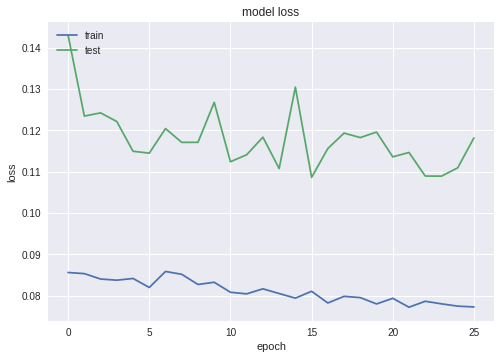

In [17]:

plt.plot(descriptor_history.history['loss'])
plt.plot(descriptor_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
from keras.models import load_model
from get_data import get_data
%cd hpatches-benchmark
!git pull 
%cd ..
!mkdir -p results

generate_desc_csv(descriptor_model, seqs_test, use_clean=False)

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=verification

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=matching

!python ./hpatches-benchmark/hpatches_eval.py --descr-name=custom --descr-dir=/content/deepLearning/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/results/ --task=retrieval

/content/deepLearning/hpatches-benchmark
Already up to date.
/content/deepLearning


100%|██████████| 40/40 [07:21<00:00, 12.82s/it]



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
/usr/local/lib/python2.7/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:24<00:00, 11898.53it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:23<00:00, 11920.57it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:24<00:00, 11871.10it/s]
>> Verification task finished in 260 secs  
Verification task results:
Mean Average Precision is 0.835874



>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
/usr/local/lib/python2.7/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some